# Predict a possible heart disease

In [1]:
!pip install scikit-learn
!pip install pandas numpy
!pip install --upgrade matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import recall_score, roc_auc_score, f1_score, accuracy_score, precision_score, classification_report, make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss 

## Load The Dataset

In [2]:
# Load The Dataset
data = pd.read_csv(r"D:\ML_Project\heart.csv")

In [3]:
# Basic Data Overview
print(data.head())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [4]:
# Checking for missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [5]:
# Check for duplicate data
print(data.duplicated().sum())

0


In [6]:
# View basic information
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


## Feature Engineering

In [4]:
# Define categorical and numerical columns
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [5]:
# Convert FastingBS to string (categorical type)
data['FastingBS'] = data['FastingBS'].astype(str)

In [6]:
# Verify the change
print(data['FastingBS'].dtypes)

object


In [7]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Apply one-hot encoding to the categorical columns
encoded_categorical = encoder.fit_transform(data[categorical_cols])

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_cols), index=data.index)

# Drop the original categorical columns from the dataset
data.drop(columns=categorical_cols, inplace=True)

# Combine the encoded features with the original dataset
data = pd.concat([data, encoded_df], axis=1)

In [8]:
# Drop the target variable 'HeartDisease' and create a feature list
feature_list = data.drop(columns=['HeartDisease']).columns.tolist()

# Print the feature list
print("Feature List:", feature_list)

Feature List: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'FastingBS_0', 'FastingBS_1', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']


In [9]:
# Initialize the standardization tool
scaler = StandardScaler()

# Standardize the numerical features
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


In [10]:
# Verify the results of standardization
print("\nNumerical columns mean and standard deviation after scaling:")
print("Means (should be approximately 0):")
print(data[numerical_cols].mean())
print("\nStandard deviations (should be approximately 1):")
print(data[numerical_cols].std())



Numerical columns mean and standard deviation after scaling:
Means (should be approximately 0):
Age           -1.083616e-16
RestingBP      1.954380e-16
Cholesterol    0.000000e+00
MaxHR          4.953675e-16
Oldpeak        1.238419e-16
dtype: float64

Standard deviations (should be approximately 1):
Age            1.000545
RestingBP      1.000545
Cholesterol    1.000545
MaxHR          1.000545
Oldpeak        1.000545
dtype: float64


In [11]:
# Final feature list
print("Final Feature List:")
print(feature_list)
# Display the first few rows of the processed data
print("Processed Training Data:")
print(data.head())

Final Feature List:
['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'FastingBS_0', 'FastingBS_1', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']
Processed Training Data:
        Age  RestingBP  Cholesterol     MaxHR   Oldpeak  HeartDisease  Sex_F  \
0 -1.433140   0.410909     0.825070  1.382928 -0.832432             0    0.0   
1 -0.478484   1.491752    -0.171961  0.754157  0.105664             1    1.0   
2 -1.751359  -0.129513     0.770188 -1.525138 -0.832432             0    0.0   
3 -0.584556   0.302825     0.139040 -1.132156  0.574711             1    1.0   
4  0.051881   0.951331    -0.034755 -0.581981 -0.832432             0    0.0   

   Sex_M  ChestPainType_ASY  ChestPainType_ATA  ...  FastingBS_0  FastingBS_1  \
0    1.0                0.0                1.0  ...          

## SVM Model

In [20]:
# Separate the target variable and features
X = data[feature_list]  # Select feature columns based on feature_list
y = data['HeartDisease']

In [21]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# Define the SVM model
svm = SVC(probability=True)

# Set up a pipeline with SVM
pipeline = make_pipeline(svm)

### case1 Grid Optimization with Recall as the Objective

In [23]:
param_grid = {
    'svc__C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter with finer granularity
    'svc__gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],  # Wider range of gamma values
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Adding the sigmoid kernel
    'svc__degree': [2, 3, 4],  # Polynomial kernel degree
    'svc__coef0': [0.0, 0.1, 0.5, 1.0],  # Bias term for polynomial and sigmoid kernels
    'svc__class_weight': [None, 'balanced']  # Handle class imbalance
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=make_scorer(recall_score),  # Optimize recall as the evaluation metric
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores for parallel computation
    verbose=2  # Display detailed progress of the grid search
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Parameters: {'svc__C': 0.01, 'svc__class_weight': None, 'svc__coef0': 0.0, 'svc__degree': 2, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [24]:
# Retrieve the best model
best_model = grid_search.best_estimator_

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-Validation Recall Scores: {cv_scores}")
print(f"Mean Recall: {cv_scores.mean()}")

# Train the model with the best parameters on the training set
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate probabilities for ROC-AUC (probability=True in SVC is required)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate and print metrics
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("\nModel Evaluation Metrics on Test Set:")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")

# Print the classification report for detailed performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Cross-Validation Recall Scores: [1. 1. 1. 1. 1.]
Mean Recall: 1.0

Model Evaluation Metrics on Test Set:
Recall: 1.0000
ROC-AUC: 0.9227
F1-Score: 0.7133
Accuracy: 0.5543
Precision: 0.5543

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.55      1.00      0.71       102

    accuracy                           0.55       184
   macro avg       0.28      0.50      0.36       184
weighted avg       0.31      0.55      0.40       184



c:\Users\lanxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lanxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lanxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Case 2 Grid Optimization with a Composite Scoring Metric

In [12]:
# Separate the target variable and features
X = data[feature_list]  # Select feature columns based on feature_list
y = data['HeartDisease']

In [13]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Define the SVM model
svm = SVC(probability=True)

# Set up a pipeline with SVM
pipeline = make_pipeline(svm)

In [32]:
# Define a custom scoring function
def custom_score(y_true, y_pred, y_proba):
    """
    Custom scoring function that combines Recall, F1-score, and ROC-AUC.
    Args:
        y_true (array): True labels
        y_pred (array): Predicted labels
        y_proba (array): Predicted probabilities (for ROC-AUC)
    Returns:
        float: Weighted combined score
    """
    # Calculate individual metrics
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)

    # Define weights for each metric
    w_recall = 0.4
    w_f1 = 0.3
    w_roc_auc = 0.3

    # Combine metrics with weights
    combined_score = w_recall * recall + w_f1 * f1 + w_roc_auc * roc_auc
    return combined_score

# Custom scorer for GridSearchCV
class WeightedScorer:
    def __init__(self, estimator):
        self.estimator = estimator

    def __call__(self, estimator, X, y):
        y_pred = estimator.predict(X)
        y_proba = estimator.predict_proba(X)[:, 1]  # Use probabilities for ROC-AUC
        return custom_score(y, y_pred, y_proba)

# Create a scorer using the custom function
custom_scorer = WeightedScorer(estimator=None)

In [33]:
# Set up the parameter grid for SVM
param_grid = {
    'svc__C': [0.01, 0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svc__degree': [2, 3, 4],
    'svc__coef0': [0.0, 0.1, 0.5, 1.0],
    'svc__class_weight': [None, 'balanced']
}

# Define the GridSearchCV with custom scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=custom_scorer,  # Use the custom scorer
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available CPU cores
    verbose=2
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Weighted Score:", grid_search.best_score_)

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Parameters: {'svc__C': 0.1, 'svc__class_weight': None, 'svc__coef0': 0.1, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}
Best Weighted Score: 0.9100864376554435


In [34]:
# Retrieve the best model
best_model = grid_search.best_estimator_

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall')
print(f"Cross-Validation Recall Scores: {cv_scores}")
print(f"Mean Recall: {cv_scores.mean()}")

# Train the model with the best parameters on the training set
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate probabilities for ROC-AUC (probability=True in SVC is required)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate and print metrics
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("\nModel Evaluation Metrics on Test Set:")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")

# Print the classification report for detailed performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Cross-Validation Recall Scores: [0.93902439 0.92592593 0.91358025 0.87654321 0.91358025]
Mean Recall: 0.9137308039747063

Model Evaluation Metrics on Test Set:
Recall: 0.9314
ROC-AUC: 0.9364
F1-Score: 0.9135
Accuracy: 0.9022
Precision: 0.8962

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        82
           1       0.90      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



## Feature Importance Analysis  

### LIME

In [36]:
pip install lime


     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ---- -------------------------------- 30.7/275.7 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Obtaining dependency information for scikit-image>=0.12 from https://files.pythonhosted.org/packages/26/72/0653e3274310972bd053fc9271aa29df2de0d51ad2db2d47b199bf6070d5/scikit_image-0.25.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for networkx>=3.0 from https://files.pythonhosted.org/packages/b9/54/dd730b32ea14ea797530a4479b2ed46a6fb250f682a9cfb997e968bf0261/networkx-3.4.2-py3-none-any.whl.metadata
  Obta


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


c:\Users\lanxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\lanxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\lanxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\lanxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\lanxi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Us

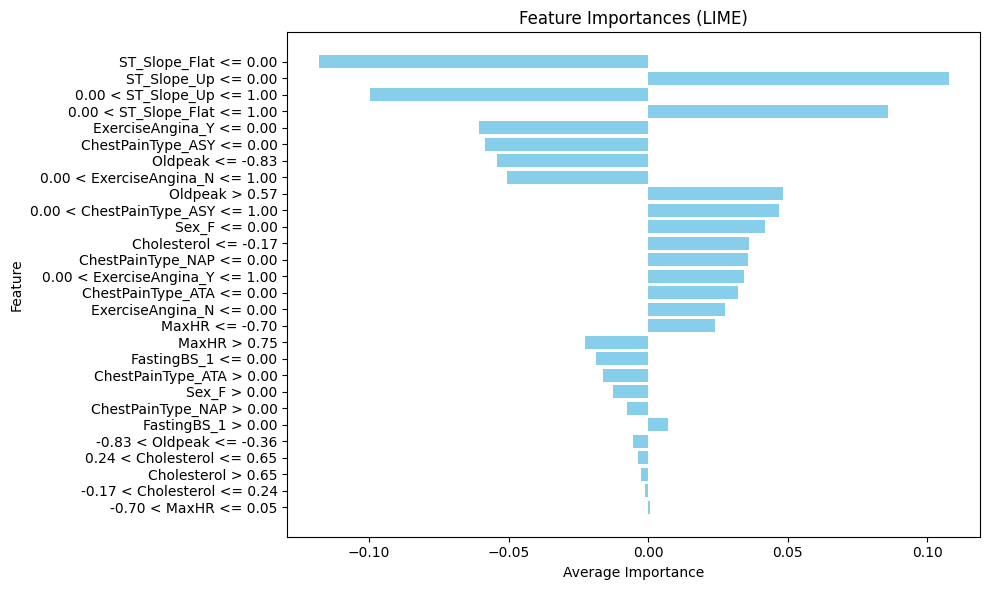


Top 10 Important Features:
                            Feature  Importance
0             ST_Slope_Flat <= 0.00   -0.117951
1               ST_Slope_Up <= 0.00    0.107525
2        0.00 < ST_Slope_Up <= 1.00   -0.099546
3      0.00 < ST_Slope_Flat <= 1.00    0.085681
4          ExerciseAngina_Y <= 0.00   -0.060500
5         ChestPainType_ASY <= 0.00   -0.058516
6                  Oldpeak <= -0.83   -0.054224
7   0.00 < ExerciseAngina_N <= 1.00   -0.050472
8                    Oldpeak > 0.57    0.048254
9  0.00 < ChestPainType_ASY <= 1.00    0.046683


In [ ]:
import random
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure the model supports probability prediction
if not hasattr(best_model, "predict_proba"):
    raise AttributeError("The SVC model must have `probability=True` enabled during training.")

# Create a LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),  # Define feature distribution using training data
    feature_names=X.columns.tolist(),  # Feature names
    class_names=['No Disease', 'Disease'],  # Class names
    mode='classification'  # Model mode is classification
)

# Target analysis: Randomly sample from the test set
num_samples = 50  # Number of samples to analyze
# Ensure samples cover the class distribution, separate random sampling
positive_indices = X_test[y_test == 1].index.tolist()  # Indices of samples in the "Disease" class
negative_indices = X_test[y_test == 0].index.tolist()  # Indices of samples in the "No Disease" class

# Random sampling from each class to ensure balance
num_positive_samples = num_samples // 2
num_negative_samples = num_samples - num_positive_samples
positive_samples = random.sample(positive_indices, min(len(positive_indices), num_positive_samples))
negative_samples = random.sample(negative_indices, min(len(negative_indices), num_negative_samples))

# Merge sample indices
sample_indices = positive_samples + negative_samples

# Initialize a dictionary to store feature importance
feature_importances = {}

# Iterate over randomly sampled test instances
for instance_index in sample_indices:
    # Retrieve a single instance
    instance = X_test.loc[instance_index].values  # Use .loc to access specific index sample
    
    # Generate explanations
    lime_exp = lime_explainer.explain_instance(
        data_row=instance,
        predict_fn=best_model.predict_proba  # Use the model's probability prediction function
    )
    
    # Retrieve each feature's contribution to importance
    for feature, importance in lime_exp.as_list(label=1):  # Focus on the "Disease" class
        if feature not in feature_importances:
            feature_importances[feature] = 0
        feature_importances[feature] += importance

# Average feature importance
feature_importances = {k: v / num_samples for k, v in feature_importances.items()}

# Sort by importance
sorted_features = sorted(feature_importances.items(), key=lambda x: abs(x[1]), reverse=True)

# Plot feature importance bar chart
features = [item[0] for item in sorted_features]
importances = [item[1] for item in sorted_features]

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (LIME)')
plt.gca().invert_yaxis()  # Reverse Y-axis to display importance from high to low
plt.tight_layout()

# Display the plot
plt.show()

# Output as a DataFrame for easier viewing
importance_df = pd.DataFrame(sorted_features, columns=["Feature", "Importance"])
print("\nTop 10 Important Features:")
print(importance_df)


